In [1]:
import uproot, numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
from scipy import stats
import random
from numpy import linalg as LA
from random import sample
from sklearn.decomposition import PCA
import pandas
from sklearn.linear_model import LinearRegression
import shapely
from termcolor import colored
from shapely.geometry import LineString, Point
class Events:
    def __init__(self, filename, treename):
        file = uproot.open(filename)
        tree = file[treename]
        self.u_x = tree["u_x"].array(library="np")
        self.u_z = tree["u_z"].array(library="np")
        self.u_energy = tree["u_energies"].array(library="np")
        self.u_pi = tree["u_pi"].array(library="np")
        self.vtx_u_z = tree["vtx_u_z"].array(library="np")
        self.end_u_z = tree["end_u_z"].array(library="np")
        self.v_x = tree["v_x"].array(library="np")
        self.v_z = tree["v_z"].array(library="np")
        self.v_energy = tree["v_energies"].array(library="np")
        self.v_pi = tree["v_pi"].array(library="np")
        self.vtx_v_z = tree["vtx_v_z"].array(library="np")
        self.end_v_z = tree["end_v_z"].array(library="np")
        self.w_x = tree["w_x"].array(library="np")
        self.w_z = tree["w_z"].array(library="np")
        self.w_energy = tree["w_energies"].array(library="np")
        self.w_pi = tree["w_pi"].array(library="np")
        self.vtx_w_z = tree["vtx_w_z"].array(library="np")
        self.end_w_z = tree["end_w_z"].array(library="np")
        self.event=tree["event"].array(library="np")
        self.vtx_x = tree["vtx_x"].array(library="np")
        self.end_x = tree["end_x"].array(library="np")
        file.close()


In [1268]:
events = Events("hierarchywriting_nue_305.root", "hierarchy_writing")

In [1269]:
np.where(events.event==4)


(array([7], dtype=int64),)

In [1271]:
#Extracting only the pion hits 
n = 35
pion_events = events.w_pi[n]
pion_indices = np.where(pion_events==1)
not_pion_indices = np.where(pion_events!=1)
length = len(pion_indices[0])
print("End point x is", events.end_x[n])
print("Vertex point x is", events.vtx_x[n])
print("Vertex point w_z is", events.vtx_w_z[n])
print("End point w_z is", events.end_w_z[n])
print(length)

End point x is [-203.01968 -250.8483 ]
Vertex point x is [-201.9838 -201.9838]
Vertex point w_z is [264.32202 264.32202]
End point w_z is [279.94247 617.5873 ]
703


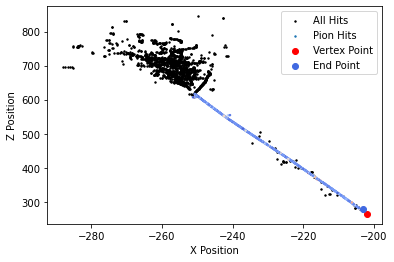

In [1272]:
energy = events.u_energy[n]
pion_x = events.w_x[n][pion_indices]
pion_z = events.w_z[n][pion_indices]
x = events.w_x[n][not_pion_indices]
y = events.w_z[n][not_pion_indices]
pion_adc = events.w_energy[n][pion_indices]

plt.scatter(x,y, s=2, label="All Hits", color="Black")
plt.scatter(pion_x,pion_z, s=2, label = "Pion Hits", c = pion_adc, cmap="coolwarm")
plt.scatter(events.vtx_x[n][0], events.vtx_w_z[n][0], color="Red", label="Vertex Point")
plt.scatter(events.end_x[n][0], events.end_w_z[n][0], color="royalblue", label = "End Point")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Z Position")
plt.show()

In [1273]:
x_hits = np.reshape(events.w_x[n], (-1,1))
z_hits = np.reshape(events.w_z[n], (-1,1))
pion_x_new = np.reshape(pion_x, (-1,1))
pion_z_new = np.reshape(pion_z, (-1,1))
#indices = list(range(len(x_hits)))
#rand_indices = sample(indices, 100)
reg = LinearRegression()  
reg.fit(x_hits, z_hits)

print(reg.intercept_)
print(reg.coef_)

[-1270.3252]
[[-7.6356044]]


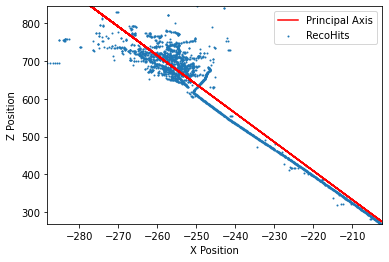

[  85 -655]
Unit vector is [ 0.1286919  -0.99168462]
Projection of hits along unit vector is [-1857.77630506 -1858.25282416 -1858.73606494 ... -1565.06677134
 -1605.28680013 -1563.59589031]


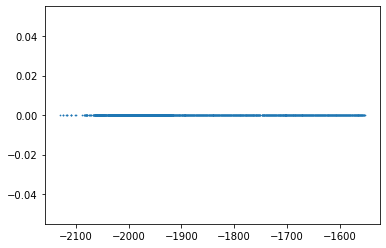

In [1274]:
z_pred = reg.predict((x_hits))
plt.scatter(x_hits, z_hits, label="RecoHits", s=1)
plt.plot(x_hits, z_pred, color='red', label="Principal Axis")
plt.xlim(min(x_hits), max(x_hits))
plt.ylim(min(z_hits), max(z_hits))
plt.xlabel("X Position")
plt.ylabel("Z Position")
plt.legend()
plt.show()

#Assigning x and z hit arrays to the n'th PFO
pfo_x = events.w_x[n]
pfo_z = events.w_z[n]
extrema_x = np.array([pfo_x.min(), pfo_x.max()])
#Using the linear regression tool to predict z hit position from x hit array
extrema_z = reg.predict(np.reshape(extrema_x, (-1,1)))
#Creating a reference/fixed point passing through 0 and the z-intercept
fixed_point = (0, reg.intercept_)
#Creating distance array which represents the principal axis, x value represents the total distance in x and z value the total distance in z
vector = np.array([extrema_x[1] - extrema_x[0], extrema_z[1] - extrema_z[0]], dtype=int)
print(vector)
#Normalise vector to define the principal axis unit vector
norm = np.sqrt(np.sum(vector ** 2))
#norm = (vector[0] ** 2 + vector[1] ** 2)**0.5


unit_vector = vector / norm

#Defining vectors for x and z to their hits from the fixed point
vec_x = pfo_x - fixed_point[0]
vec_z = pfo_z - fixed_point[1]
#Concatenate these vectors together into a single hit vector
hit_vector = np.concatenate((vec_x[:, None], vec_z[:, None]), axis=1)
print("Unit vector is", unit_vector)

#Use dot product to project hit vector onto the unit vector
projection_array = np.array(np.dot(hit_vector, unit_vector))
print("Projection of hits along unit vector is" , projection_array)

yy = np.zeros_like(projection_array)
#print(yy)
plt.scatter(projection_array, yy, s=0.5)


-1552.969128470231 -2129.6913421745803
[-2129.69134217 -2122.69134217 -2115.69134217 -2108.69134217
 -2101.69134217 -2094.69134217 -2087.69134217 -2080.69134217
 -2073.69134217 -2066.69134217 -2059.69134217 -2052.69134217
 -2045.69134217 -2038.69134217 -2031.69134217 -2024.69134217
 -2017.69134217 -2010.69134217 -2003.69134217 -1996.69134217
 -1989.69134217 -1982.69134217 -1975.69134217 -1968.69134217
 -1961.69134217 -1954.69134217 -1947.69134217 -1940.69134217
 -1933.69134217 -1926.69134217 -1919.69134217 -1912.69134217
 -1905.69134217 -1898.69134217 -1891.69134217 -1884.69134217
 -1877.69134217 -1870.69134217 -1863.69134217 -1856.69134217
 -1849.69134217 -1842.69134217 -1835.69134217 -1828.69134217
 -1821.69134217 -1814.69134217 -1807.69134217 -1800.69134217
 -1793.69134217 -1786.69134217 -1779.69134217 -1772.69134217
 -1765.69134217 -1758.69134217 -1751.69134217 -1744.69134217
 -1737.69134217 -1730.69134217 -1723.69134217 -1716.69134217
 -1709.69134217 -1702.69134217 -1695.69134217 

Text(0, 0.5, 'Pion Fractional Energy')

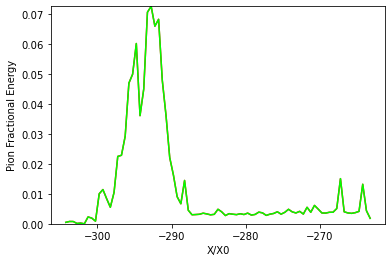

In [1275]:

#Binning the hits
#Finding min and max values of projected hits 
max_value = max(projection_array)
min_value = min(projection_array)
print(max_value, min_value)

#Small adjustment to avoid overflow bin
max_value_adjusted = max_value + 1e-5
min_value_adjusted = min_value - 1e-5

#Defining the bins
#1. Define the radiation length
rad_length = 14
half_rad_length = rad_length/2

#2. Find the length scale
length = (max_value - min_value)

#3. Determine no. bins
number_bins = np.int(np.ceil(length/half_rad_length))


#4. Setting maximum 
maximum = number_bins*half_rad_length + min_value
bin_edges = np.linspace(min_value, maximum, number_bins +1)
print(bin_edges)
bin_edges_fraction = (bin_edges/rad_length) - abs(min(bin_edges)/rad_length)


#5. Binning
bin_indices = np.digitize(projection_array, bin_edges) -1 

print(bin_indices)
print(number_bins)


#6. Getting energies and plotting energy histogram
energy_array = events.w_energy[n]
#plt.hist(energy_array, number_bins)

energy_profile = np.zeros(number_bins)

for i in range(len(energy_array)):
    index = bin_indices[i] 
    energy_profile[index]=energy_array[i]+energy_profile[index]
    
print(energy_profile)
print(bin_edges_fraction)
    
fractional_energy = energy_profile/sum(energy_profile)

plt.plot((bin_edges_fraction[:-1]), fractional_energy, color='Red')
plt.ylim(0, max(fractional_energy))
plt.xlabel('X/X0')
plt.ylabel('Fractional Energy')

#Pion energy profile
energy_profile_pion = np.zeros(number_bins)

for i in range(len(energy_array)):
    index = bin_indices[i] 
    energy_profile_pion[index]+=energy_array[i] if events.w_pi[n][i]==1 else 0
  
fractional_energy_pion = energy_profile_pion/sum(energy_profile_pion)

plt.plot((bin_edges_fraction[:-1]), fractional_energy, color='Lime')
plt.ylim(0, max(fractional_energy))
plt.xlabel('X/X0')
plt.ylabel('Pion Fractional Energy')

Principal axes: [[ 0.1188248  -0.99291515]
 [-0.99291515 -0.1188248 ]]
Explained variance: [18676.412       24.850428]
Mean: [-201.9838, 264.32202]
[ 0.1188248  -0.99291515]


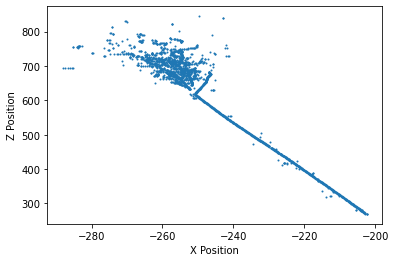

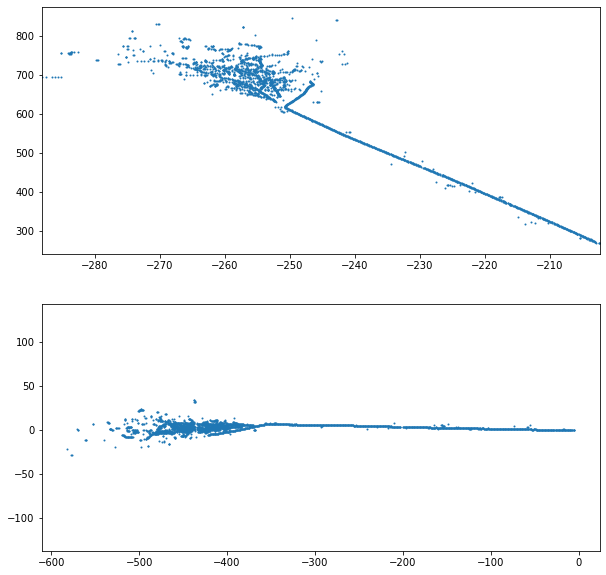

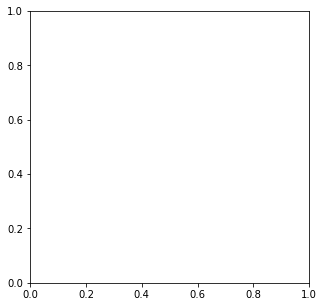

In [1276]:
#PCA
#origin = (np.mean(x_hits), np.mean(z_hits))
pca1=PCA(2)
total_hits = np.concatenate((pfo_x[:, None], pfo_z[:, None]), axis=1)
pca1.fit(total_hits)
pca1.mean_ = [events.vtx_x[n][0], events.vtx_w_z[n][0]]
print("Principal axes:", pca1.components_)
print("Explained variance:", pca1.explained_variance_)
print("Mean:", pca1.mean_)
print(pca1.components_[0, :])
plt.scatter(total_hits[:, 0], total_hits[:, 1], s=1)
plt.xlabel('X Position')
plt.ylabel('Z Position')
#plt.quiver(*pca1.mean_, *pca1.components_[0, :], color="Red", scale=3)
#plt.quiver(*pca1.mean_, *pca1.components_[1, :], color="Blue", scale=7)

Z=pca1.transform(total_hits)
fig, axes = plt.subplots(2,1, figsize=(10,10))
axes[0].scatter(total_hits[:,0], total_hits[:,1], s=1)
axes[0].set_xlim(min(total_hits[:, 0]), max(total_hits[:,0]))
axes[1].set_xlim(min(Z[:, 0]), max(Z[:,0]))
axes[1].scatter(Z[:,0], Z[:,1], s=1)

#pca2=PCA(1)
y_zero = np.zeros_like(Z[:, 0])
plt.axis('equal')
#plt.scatter(Z[:,0], y_zero, marker="d", alpha=1, s=0.5)

#PCA Transform
end_x = events.end_x[n]
end_z = events.end_w_z[n]

fig,ax = plt.subplots(figsize=(5, 5))

#v1 = [[pca1.mean_[0], (pca1.mean_ + 20 * pca1.components_[0])[0]],
      #[pca1.mean_[1], (pca1.mean_ + 20 * pca1.components_[0])[1]]]
#ax.plot(v1[0], v1[1], color='red', lw=3)
#v2 = [[pca1.mean_[0], (pca1.mean_ + 20 * pca1.components_[1])[0]],
     # [pca1.mean_[1], (pca1.mean_ + 20 * pca1.components_[1])[1]]]pca ski
#ax.plot(v2[0], v2[1], color='blue', lw=3)


-5.090965 -582.0552
[-582.05517578 -575.05517578 -568.05517578 -561.05517578 -554.05517578
 -547.05517578 -540.05517578 -533.05517578 -526.05517578 -519.05517578
 -512.05517578 -505.05517578 -498.05517578 -491.05517578 -484.05517578
 -477.05517578 -470.05517578 -463.05517578 -456.05517578 -449.05517578
 -442.05517578 -435.05517578 -428.05517578 -421.05517578 -414.05517578
 -407.05517578 -400.05517578 -393.05517578 -386.05517578 -379.05517578
 -372.05517578 -365.05517578 -358.05517578 -351.05517578 -344.05517578
 -337.05517578 -330.05517578 -323.05517578 -316.05517578 -309.05517578
 -302.05517578 -295.05517578 -288.05517578 -281.05517578 -274.05517578
 -267.05517578 -260.05517578 -253.05517578 -246.05517578 -239.05517578
 -232.05517578 -225.05517578 -218.05517578 -211.05517578 -204.05517578
 -197.05517578 -190.05517578 -183.05517578 -176.05517578 -169.05517578
 -162.05517578 -155.05517578 -148.05517578 -141.05517578 -134.05517578
 -127.05517578 -120.05517578 -113.05517578 -106.05517578 

Text(0, 0.5, 'Fractional Energy')

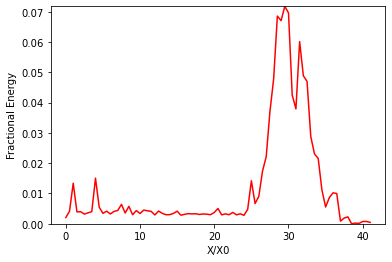

In [1277]:
#Binning the hits
#Finding min and max values of projected hits 
max_value = max(Z[:, 0])
min_value = min(Z[:, 0])
print(max_value, min_value)

#Small adjustment to avoid overflow bin
max_value_adjusted = max_value + 1e-5
min_value_adjusted = min_value - 1e-5

#Defining the bins
#1. Define the radiation length
rad_length = 14
half_rad_length = rad_length/2

#2. Find the length scale
length = (max_value - min_value)

#3. Determine no. bins
number_bins = np.int(np.ceil(length/half_rad_length))


#4. Setting maximum 
maximum = number_bins*half_rad_length + min_value
bin_edges = np.linspace(min_value, maximum, number_bins +1)
print(bin_edges)
bin_edges_fraction = (bin_edges/rad_length) 


#5. Binning
bin_indices = np.digitize(Z[:, 0], bin_edges) -1 

print(bin_indices)
print(number_bins)


#6. Getting energies and plotting energy histogram
energy_array = events.w_energy[n]
#plt.hist(energy_array, number_bins)

energy_profile = np.zeros(number_bins)

for i in range(len(energy_array)):
    index = bin_indices[i] 
    energy_profile[index]=energy_array[i]+energy_profile[index]
energy_profile=energy_profile[::-1]
    
print("Min value", min_value)
print(bin_edges_fraction)
    
fractional_energy = energy_profile/sum(energy_profile)
print(fractional_energy)

shifted_bin_edges_fraction = bin_edges_fraction + abs(min(bin_edges_fraction))
plt.plot((shifted_bin_edges_fraction[:-1]), fractional_energy, color='Red')
plt.ylim(0, max(fractional_energy))
plt.xlabel('X/X0')
plt.ylabel('Fractional Energy')

Gradient is [ 9.33505802e+02  2.55534870e+03 -4.32684364e+01 -2.11880475e+03
 -1.63018898e+02 -8.34925575e+01  1.78906740e+02  2.57853263e+03
  3.31666590e+02 -2.61310686e+03 -2.96426670e+02 -5.03969955e+01
 -1.50446815e+01  2.62733768e+02  5.22230671e+02 -1.90187206e+02
 -1.46837162e+02 -1.29101345e+02 -3.13142136e+02  9.05762253e+01
  3.55471649e+01  2.01095930e+02 -9.34057045e+01 -3.06385380e+02
  2.07814407e+01  1.19983038e+02 -2.74069241e+02 -9.88694801e+01
  9.76873035e+01  2.58670483e+02 -1.30499834e+02 -2.36984428e+02
  1.13496269e+02  3.31119766e+01 -5.69757843e+00 -4.13887596e+01
 -1.65376472e+01  1.95835915e+01 -5.25332603e+01  1.27139107e+02
  4.58139473e+02 -1.75369436e+02 -3.97399441e+02  9.98870659e+00
  1.05556801e+02 -9.68831253e+00 -1.00670094e+02 -3.62256603e+01
  3.25995495e+02  2.57482125e+03  4.34066902e+02 -1.16803473e+03
  2.41599062e+03  2.96809363e+03  4.44007749e+03  5.78961282e+03
  7.10454119e+03  4.32966037e+03  7.23254652e+02  5.80455449e+02
 -6.60140888e

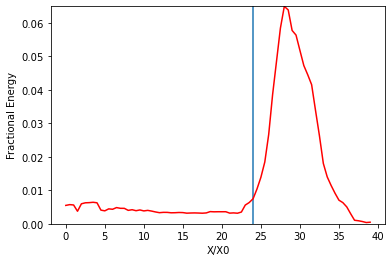

In [1282]:
#Determining transition points

number = 5

#Calculate the gradient of the energy profile and form a gradient array 
gradient = np.gradient(energy_profile)
print("Gradient is", gradient)

#Set number of bins
bin_number = np.int(np.ceil(len(gradient)/number)) 

#Binning 
mean_grad = np.convolve(gradient, np.ones(number)/number, mode='valid')
print("Running average", mean_grad)
        
mean_energy = np.zeros(bin_number) 
mean_energy = np.convolve(fractional_energy, np.ones(number)/number, mode='valid')
print(("Mean energy", mean_energy))
    
#plt.plot(bin_edges_new, mean_grad, color="Red")

#Setting a threshold within which the gradient shall be considered zero 
grad_range = (max(gradient)-min(gradient))
threshold_value = 0.15 * grad_range

#Determining the values in bin_edges_new where the mean gradient is zero and placing these in a track_edges array
track_edges = []
track_indices = []
for p in range(len(mean_grad)):
    if 0 - threshold_value <= mean_grad[p] <= 0 + threshold_value:
        track_edges.append(bin_edges_fraction[p])
        track_indices.append(p)
        
print("Track edges", track_edges)
print("Track indices", track_indices)


#If the track edges are continuous i.e 2, 3, 4 and there are 3 or more consecutive indices then determine the start point of the track
diff=[]
for m in range(len(track_indices)):
    diff.append(track_indices[m] - track_indices[m-1])
    track_diff = (diff[1:len(track_indices)])

print("Track difference", track_diff)

#In track_diff, element 0 is the difference between element 0 and 1 in track_indices etc.
track_transition=[]

#Consecutive number (cons_number) is the amount of consecutive 1's in track_diff that are required
size_track_diff = len(track_diff)
end =[]

for p in range(len(mean_grad) - 2):
    if mean_grad[p] < mean_grad[p+1] < mean_grad[p+2]  and mean_grad[p+2] - mean_grad[p+1] > 500:
        print(p) 
        track_transition.append(bin_edges_fraction[p+1])
        print("Gradient amplitude", mean_grad[p+1]-mean_grad[p])
        
print("Track transition", track_transition)
if not track_transition:
    print(colored('Cut cannot be made', 'red'))
else:
    print(colored('Cut can be made', 'green'))
    track_cut = track_transition[0]
    plt.axvline(x=track_cut-min(bin_edges_fraction))
    plt.plot(bin_edges_fraction[:-number] - min(bin_edges_fraction), mean_energy, color="Red") 
    plt.ylim(0, max(mean_energy))
    #plt.xlim(-1)
    plt.xlabel('X/X0')
    plt.ylabel('Fractional Energy')
    bin_transition = track_cut * rad_length
    print("Bin transition", bin_transition)
    print("Length mean_grad", len(mean_grad))
    print("Length bin_edges_fraction", len(bin_edges_fraction))
    shifted_track_cut = track_cut - events.vtx_x[n][0]
    shifted_bin_transition = shifted_track_cut * rad_length
    
#Plotting gradient information

#plt.plot(bin_edges_fraction[:-number], mean_grad, label = "Averaged Gradient")



    

-582.0552
[-203.01968 -250.8483 ]
[[566.42230214 581.22762811]]
Bin transition is -246.05517578125
End point in PCA space is [[566.42230214 581.22762811]]
Split difference (%) [[-320.36712636 -335.17245233]]
-246.05517578125
51
[55 48]


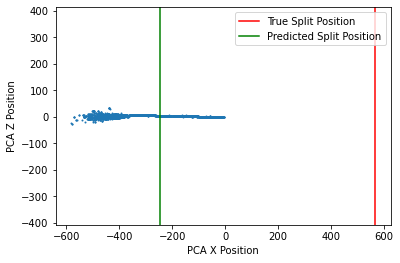

In [1289]:
#Plotting on PCA axis
print(min_value)
print(end_x)
if not track_transition:
    print(colored('Cut cannot be made', 'red'))
else:
    end_PCA = pca1.transform([[end_x[0], end_z[0]]])- min_value
    print(end_PCA)
    plt.axvline(x=end_PCA[0][0], color="Red", label = 'True Split Position')
    shifted_Z = Z
    plt.axis('equal')
    plt.scatter(shifted_Z[:,0], shifted_Z[:, 1], s=1)
    plt.xlabel('PCA X Position')
    plt.ylabel('PCA Z Position')
    plt.axvline(x=bin_transition, color="Green", label = 'Predicted Split Position')
    plt.legend()

    print("Bin transition is", bin_transition)
    track_start_x=(pca1.inverse_transform(bin_transition)[:, 0][0])
    print("End point in PCA space is", end_PCA)
    
    split_goodness = (abs(bin_transition) - abs(end_PCA))
    print("Split difference (%)" , split_goodness)

#Binning end point
print(bin_transition)
end_index_predicted = np.digitize(track_start_x, bin_edges)
print(end_index_predicted)

end_index_true = np.digitize(end_x, bin_edges)
print(end_index_true)


406 406


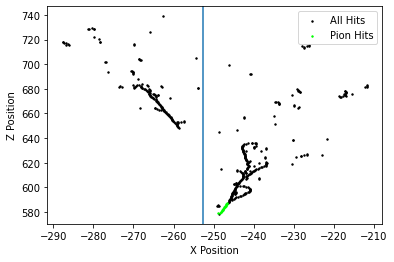

In [1267]:
print(len(x), len(y))
if not track_transition:
    print(colored('Cut cannot be made', 'red'))
else:
    plt.scatter(x,y, s=2, label="All Hits", color="Black")
    plt.scatter(pion_x,pion_z, s=2, label = "Pion Hits", color="Lime")
    plt.axvline(x=track_start_x)
    plt.legend()
    plt.xlabel("X Position")
    plt.ylabel("Z Position")
    plt.show()

6
0.0
range(0, 29)
[1212.5887352  1272.26836243 1191.7635704  1201.70266953 1292.552771
 1319.37853622]
[-10.14775630405971, -7.64775630405971, -5.14775630405971, -2.6477563040597096, -0.39775630405970985]
[1, 2, 3, 4, 5]
[379.40648766   6.98106918   4.0562973  -15.01004906  38.1001152
  37.47464689]
Track difference [1, 1, 1, 1]
[0, 1, 2]
[-10.14775630405971, -7.64775630405971, -5.14775630405971]
Bin transition start -142.06858825683594


NameError: name 'track_end' is not defined

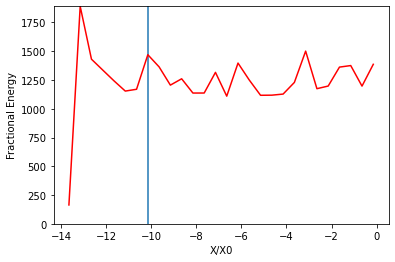

In [879]:
#Determining transition points
number = 5
#Calculate the gradient of the energy profile and form a gradient array 
gradient = np.gradient(energy_profile)

#Calculating the gradient over 5 elements in the gradient array
array_size = np.int(np.ceil(len(gradient)/number))
print(array_size)

#Mean gradient array contains the average gradient for every five elements in gradient i.e.
#average over first 5 elements in gradient forms the 0th element in mean_grad
mean_grad = np.zeros(array_size)
print(max(mean_grad))
i = 0
for k in range(len(gradient)):
    if max(mean_grad) == min(mean_grad) + 0.1 * np.mean(mean_grad):
        pass
    if k%number ==0:
        average = np.array(np.mean(gradient[k:k+number]))
        mean_grad[i]=average
        i=i+1  

#Creating new bin edges to fit the averaged gradient
bin_edges_new = np.zeros(array_size+1)

n = 0
print(range(len(bin_edges_fraction)))
for r in range(len(bin_edges_fraction)):
    if r%number ==0:
        average_bin = np.array(np.mean(bin_edges_fraction[r:r+number]))
        bin_edges_new[n]=average_bin
        n=n+1  
        
mean_energy = np.zeros(array_size)
p = 0
for t in range(len(energy_profile)):
     if t%number ==0:
        average_energy = np.array(np.mean(energy_profile[t:t+number]))
        mean_energy[p]=average_energy
        p=p+1 
print((mean_energy))
    
#plt.plot(bin_edges_new, mean_grad, color="Red")

#Setting a threshold within which the gradient shall be considered zero 
grad_range = (max(gradient)-min(gradient))
threshold_value = 0.15 * grad_range

#Determining the values in bin_edges_new where the mean gradient is zero and placing these in a track_edges array
track_edges = []
track_indices = []
for p in range(len(mean_grad)):
    if 0-threshold_value <= mean_grad[p] <= 0 + threshold_value:
        track_edges.append(bin_edges_new[p])
        track_indices.append(p)
        
print(track_edges)
print(track_indices)
print(mean_grad)
#If the track edges are continuous i.e 2, 3, 4 and there are 3 or more consecutive indices then determine the start point of the track
diff=[]
for m in range(len(track_indices)):
    diff.append(track_indices[m] - track_indices[m-1])
    track_diff = (diff[1:len(track_indices)])

print("Track difference", track_diff)
#In track_diff, element 0 is the difference between element 0 and 1 in track_indices etc.
track_transition=[]
end=[]
cons_number = 1
#Consecutive number (cons_number) is the amount of consecutive 1's in track_diff that are required
size_track_diff = len(track_diff)
for k in range(size_track_diff - cons_number):
    if track_diff[k] == track_diff[k+cons_number-1] == track_diff[k+cons_number] ==1 and mean_energy[k] >= 1000:
        track_transition.append(track_edges[k])
        end.append(k)
    
print(end)
print(track_transition)

#track_end = track_edges[end[0]]
track_start = track_transition[0]

plt.axvline(x=track_start)
#plt.axvline(x=track_end)
plt.plot((bin_edges_fraction[:-1]), energy_profile, color='Red')
plt.ylim(0, max(energy_profile))
plt.xlabel('X/X0')
plt.ylabel('Fractional Energy')

bin_transition_start = track_start * rad_length
print("Bin transition start", bin_transition_start)
bin_transition_end = track_end * rad_length
print("Bin transition end", bin_transition_end)

#Plotting gradient information
print(mean_grad)
print(bin_edges_fraction)
plt.scatter(bin_edges_fraction[:-1], mean_grad)
plt.ylim(min(mean_grad)-10)


In [ ]:
#PCA
origin = (np.mean(x_hits), np.mean(z_hits))
pca1=PCA(2)
total_hits = np.concatenate((pfo_x[:, None], pfo_z[:, None]), axis=1)
pca1.fit(total_hits)
print("Principal axes:", pca1.components_)
print("Explained variance:", pca1.explained_variance_)
print("Mean:", pca1.mean_)


Z=pca1.transform(total_hits)/rad_length
fig, axes = plt.subplots(1,1)
axes.set_xlim(min(Z[:, 0]), max(Z[:,0]))
axes.scatter(-Z[:,0], Z[:,1], s=1)

pca2=PCA(1)
y_zero = np.zeros_like(Z[:, 0])
plt.axis('equal')
plt.scatter(-Z[:,0], y_zero, marker="d", alpha=1, s=1)

#PCA Transform
end_x = events.end_x[n][0]
end_z = events.end_w_z[n]

plt.plot(bin_edges_fraction[:-1], fractional_energy*10, color="Green")
